In [1]:
import numpy as np

import torch
from src.tokenizers.kmeans import KMeansTokenizer
from src.tokenizers.bpe import BPETokenizer
from src.tokenizers.bert import BERTTokenizer
from src.tokenizers.nn_fft import FFTTokenizer

from src.datasets import collect_metaworld_trajectories
from src.visualizations import plot_noiseness
from src.metrics.compression import measure_compression
from src.metrics.reconstruction_quality import evaluate_reconstruction_quality
from src.metrics.information_preservation import measure_information_preservation

/home/stepan-grigorov/Private/vla_research/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [ ]:
# increase trajectories to 1000 for better experience
trajectories = collect_metaworld_trajectories("pick-place-v3", num_trajectories=100)

train_trajectories = trajectories[:80]
test_trajectories = trajectories[80:]

In [6]:
train_actions = np.concatenate(train_trajectories)
test_actions = np.concatenate(test_trajectories)

print(f"Collected {len(train_actions)} train action vectors")
print(f"Train action shape: {train_actions[0].shape}")

print(f"Collected {len(test_actions)} test action vectors")
print(f"Test action shape: {test_actions[0].shape}")

print(f"Collected {len(trajectories)} trajectories")
print(
    f"Training: {len(train_actions)} actions from {len(train_trajectories)} trajectories"
)
print(
    f"Testing: {len(test_actions)} actions from {len(test_trajectories)} trajectories"
)

Collected 16000 train action vectors
Train action shape: (4,)
Collected 4000 test action vectors
Test action shape: (4,)
Collected 100 trajectories
Training: 16000 actions from 80 trajectories
Testing: 4000 actions from 20 trajectories


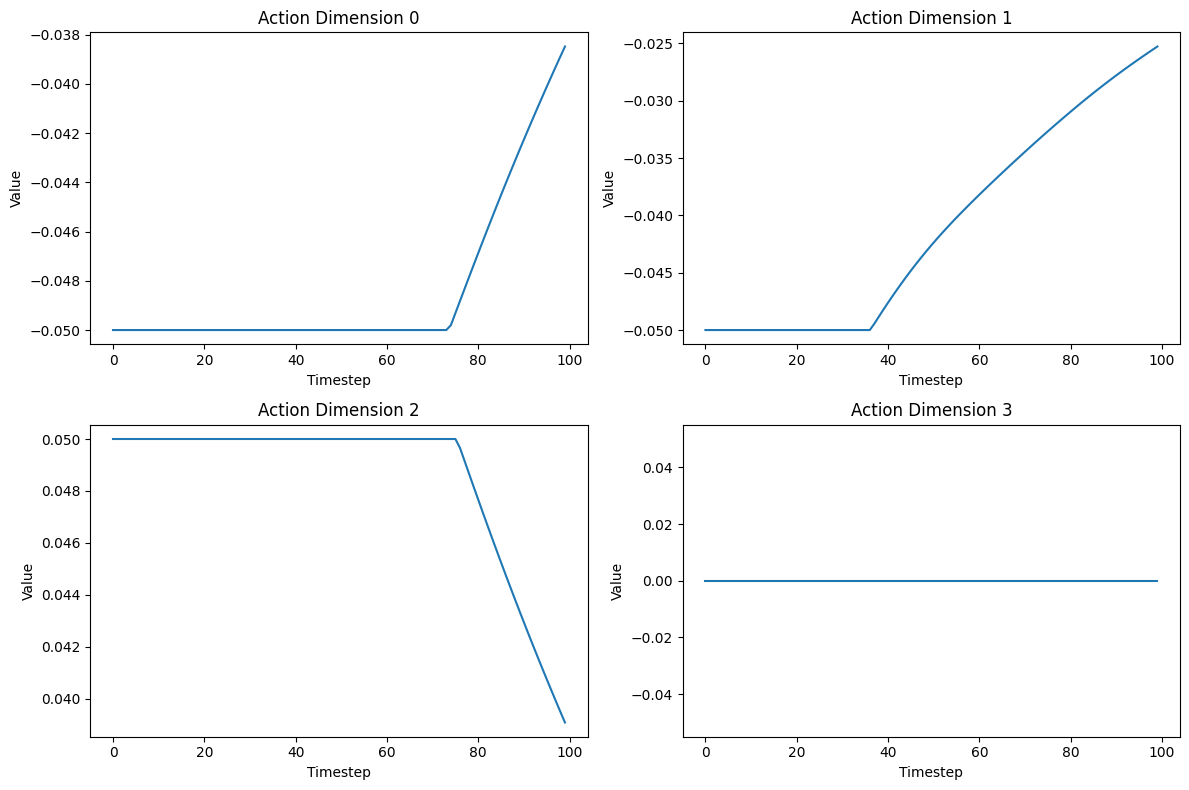

Average change per step: 0.1011
Max change per step: 0.9878


In [7]:
plot_noiseness(train_actions)

# Calculate action differences between consecutive steps
train_action_deltas = np.diff(train_actions, axis=0)
print(f"Average change per step: {np.mean(np.abs(train_action_deltas)):.4f}")
print(f"Max change per step: {np.max(np.abs(train_action_deltas)):.4f}")

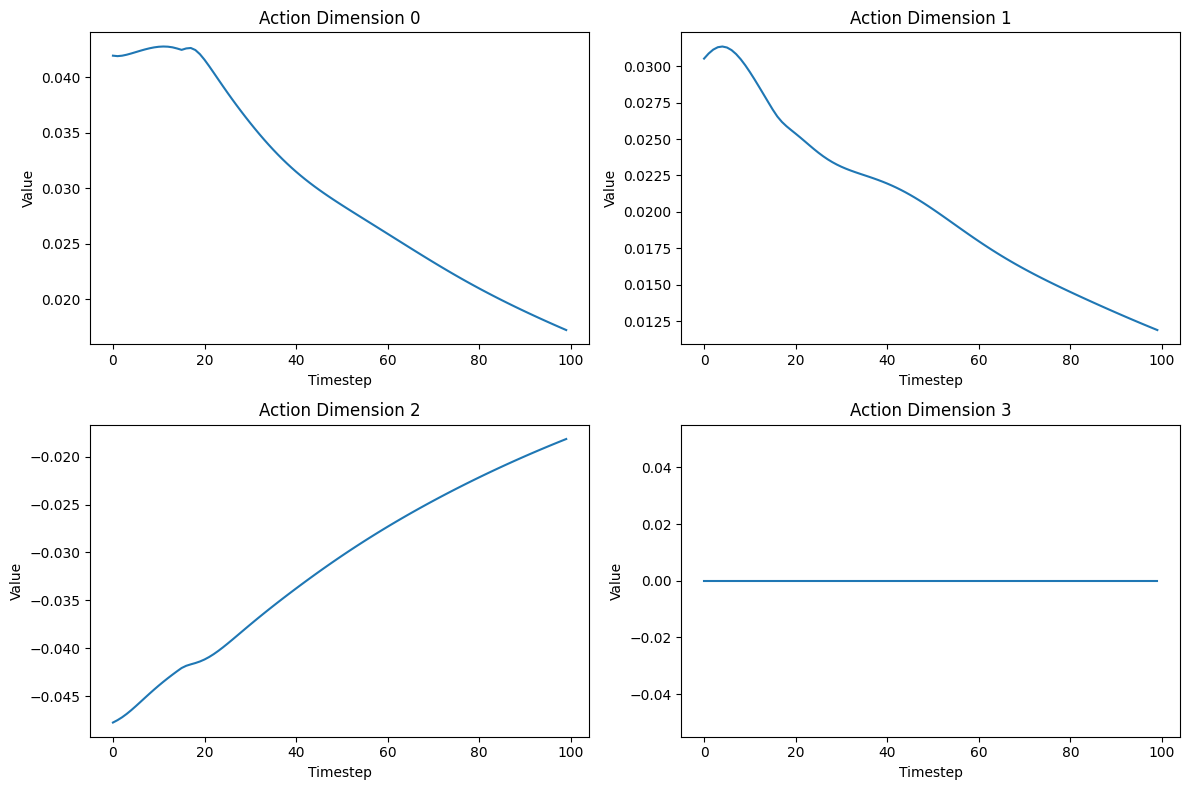

Average change per step: 0.1020
Max change per step: 0.9848


In [8]:
plot_noiseness(test_actions)

# Calculate action differences between consecutive steps
test_action_deltas = np.diff(test_actions, axis=0)
print(f"Average change per step: {np.mean(np.abs(test_action_deltas)):.4f}")
print(f"Max change per step: {np.max(np.abs(test_action_deltas)):.4f}")

### KMeans Tokenizer

In [9]:
# Reconstruction quality for KMeans tokenizer
kmeans_tokenizer = KMeansTokenizer(
    train_data=train_actions, n_clusters=10, random_state=random_state
)

kmeans_rq_results = evaluate_reconstruction_quality(kmeans_tokenizer, test_actions)

print(f"Overall MSE: {kmeans_rq_results['mse']:.6f}")
print(f"Overall MAE: {kmeans_rq_results['mae']:.6f}")
print(f"Per-dimension MSE: {kmeans_rq_results['dim_mse']}")
print(f"Per-dimension MAE: {kmeans_rq_results['dim_mae']}")

Overall MSE: 0.009747
Overall MAE: 0.057877
Per-dimension MSE: [0.01085762 0.00962071 0.00921721 0.00929128]
Per-dimension MAE: [0.06382982 0.06257087 0.06173644 0.04337116]


In [10]:
# Information perserved using KMeans tokenizer
kmeans_tokenizer = KMeansTokenizer(
    train_data=train_actions, n_clusters=10, random_state=random_state
)

kmeans_info_score_results = measure_information_preservation(
    kmeans_tokenizer, test_actions
)

print(f"Information preservation (R²): {kmeans_info_score_results:.3f}")

Information preservation (R²): 0.617


In [11]:
# Compression using KMeans tokenizer
kmeans_tokenizer = KMeansTokenizer(
    train_data=train_actions, n_clusters=10, random_state=random_state
)

kmeans_compression_results = measure_compression(kmeans_tokenizer, test_actions)

print(f"Compression Ratio: {kmeans_compression_results['compression_ratio']:.1f}x")
print(f"Max RLE Potential: {kmeans_compression_results['max_rle_compression']:.1f}x")

Compression Ratio: 32.0x
Max RLE Potential: 3.6x


### BPE Tokenizer

In [12]:
# Compression using BPE tokenizer
bpe_tokenizer = BPETokenizer(train_data=train_actions)

bpe_compression_results = measure_compression(bpe_tokenizer, test_actions)

print(f"Compression Ratio: {bpe_compression_results['compression_ratio']:.1f}x")
print(f"Max RLE Potential: {bpe_compression_results['max_rle_compression']:.1f}x")




Compression Ratio: 1.9x
Max RLE Potential: 18960.5x


### BERT Tokenizer

In [13]:
# Compression using BERT tokenizer
bert_tokenizer = BERTTokenizer()

bert_compression_results = measure_compression(bert_tokenizer, test_actions)

print(f"Compression Ratio: {bert_compression_results['compression_ratio']:.1f}x")
print(f"Max RLE Potential: {bert_compression_results['max_rle_compression']:.1f}x")

Compression Ratio: 66.7x
Max RLE Potential: 1.0x


### Custom FFT Tokenizer

In [14]:
# Custom FFT tokenizer
fft_tokenizer = FFTTokenizer(device=device, seed=random_state)
fft_tokenizer.train(train_actions, epochs=50)

Epoch 1/50 - Loss: 3.571081
Epoch 2/50 - Loss: 3.502567
Epoch 3/50 - Loss: 3.436510
Epoch 4/50 - Loss: 3.372305
Epoch 5/50 - Loss: 3.308885
Epoch 6/50 - Loss: 3.245350
Epoch 7/50 - Loss: 3.182196
Epoch 8/50 - Loss: 3.120568
Epoch 9/50 - Loss: 3.059775
Epoch 10/50 - Loss: 2.998161
Epoch 11/50 - Loss: 2.935402
Epoch 12/50 - Loss: 2.871981
Epoch 13/50 - Loss: 2.807298
Epoch 14/50 - Loss: 2.740972
Epoch 15/50 - Loss: 2.673028
Epoch 16/50 - Loss: 2.603444
Epoch 17/50 - Loss: 2.532388
Epoch 18/50 - Loss: 2.459333
Epoch 19/50 - Loss: 2.384148
Epoch 20/50 - Loss: 2.306849
Epoch 21/50 - Loss: 2.227445
Epoch 22/50 - Loss: 2.146501
Epoch 23/50 - Loss: 2.064912
Epoch 24/50 - Loss: 1.982332
Epoch 25/50 - Loss: 1.899628
Epoch 26/50 - Loss: 1.816427
Epoch 27/50 - Loss: 1.732673
Epoch 28/50 - Loss: 1.648700
Epoch 29/50 - Loss: 1.564845
Epoch 30/50 - Loss: 1.481552
Epoch 31/50 - Loss: 1.399114
Epoch 32/50 - Loss: 1.317467
Epoch 33/50 - Loss: 1.237010
Epoch 34/50 - Loss: 1.158149
Epoch 35/50 - Loss: 1.0

In [15]:
fft_compression_results = measure_compression(fft_tokenizer, test_actions)
print(f"Compression Ratio: {fft_compression_results['compression_ratio']:.1f}x")
print(f"Max RLE Potential: {fft_compression_results['max_rle_compression']:.1f}x")

Compression Ratio: 14.2x
Max RLE Potential: 17.7x
